<div style="background-color:white;" >
<div style="clear: both; display: table;">
  <div style="float: left; width: 14%; padding: 5px; height:auto">
    <img src="img/TUBraunschweig_CO_200vH_300dpi.jpg" alt="TU_Braunschweig" style="width:100%">
  </div>
  <div style="float: left; width: 28%; padding: 5px; height:auto">
    <img src="img/TU_Clausthal_Logo.png" alt="TU_Clausthal" style="width:100%">
  </div>
  <div style="float: left; width: 25%; padding: 5px; height:auto">
    <img src="img/ostfalia.jpg" alt="Ostfalia" style="width:100%">
  </div>
  <div style="float: left; width: 21%; padding: 5px;">
    <img src="img/niedersachsen_rgb_whitebg.png" alt="Niedersachsen" style="width:100%">
  </div>
  <div style="float: left; width: 9%; padding: 5px;">
    <img src="img/internet_BMBF_gefoerdert_2017_en.jpg" alt="bmbf" style="width:100%">
  </div>
</div>
<div style="text-align:center">
<img src="img/ki4all.jpg" alt="KI4ALL-Logo" width="200"/>
</div>
</div>

# Synthetic Biomedical Data – Lesson 3a: Irrelevant Features (Noise)

Part of the *Microcredit Biomedical Data Generator* learning module. We focus on *irrelevant features* (pure noise) and how they impact model training and evaluation.

➡️ [Back to Lesson 2b: Feature Distributions and Effect Size](02b_feature_distributions_effect_size.ipynb)
➡️ [Module Overview (README)](../README.md)

---

### Recap from Lesson 2
You:
- Generated synthetic datasets and checked **class balance**.
- Explored **scatterplots** and **feature distributions**.
- Quantified separation with **effect size** (Cohen’s d, Cliff’s delta).

Now we focus on **irrelevant features** — variables that add *no* useful information about the label.


### What you'll learn in 03a

- How to start from a **clean baseline dataset** with only informative features.
- How to **add purely irrelevant (noise) features** using `biomedical-data-generator`.
- How to verify ground-truth **feature roles** (`informative`, `pseudo`, `noise`) via `DatasetMeta`.
- How to control **noise distributions** (normal, uniform, laplace) and reproducibility.

After this lesson, you will be able to:
1. Generate a clean baseline and verify feature roles via `meta`.
2. **Add irrelevant features** (pure noise) to a dataset with different distributions and scales.
3. **Visualize** how noise features look vs. informative features.
4. **Quantify** which features carry signal using effect size.
5. **Explain** why irrelevant features complicate training and feature selection.

### Introduction: What are irrelevant features?

In real biomedical datasets, not every measurement is useful.
Some variables carry **no information** about the outcome of interest.
These are called **irrelevant features** (or **noise features**).

- **Examples in practice**
  - A patient’s shoe size when predicting cancer outcome.
  - Random measurement fluctuations due to instrument sensitivity.
  - Biomarkers that are measured but unrelated to the studied disease.


- **Why they matter**
  - Too many irrelevant features can **hide the true signal**.
  - They increase the risk of **overfitting**, as models may chase patterns in noise.
  - They slow down training and make feature selection more difficult.

In this lesson, we will **add irrelevant features to a synthetic dataset**
and see how they appear in plots and effect size rankings.
This builds directly on what you learned in Lesson 2 about feature distributions and effect size.

### Switch from `sklearn.make_classification` to `biomedical-data-generator`

In earlier notebooks we used `sklearn.make_classification` to synthesize data.
For this lesson onward we switch to the **biomedical-data-generator** because it gives us
didactic guarantees and metadata that are essential for teaching *feature roles* and
for running controlled benchmarks.

#### What was missing in `make_classification`
- **No explicit ground-truth roles** in the returned object (you can’t easily recover which
  columns are informative vs. redundant/repeated).
- **Limited control over noise** (mostly Gaussian) and no simple way to label “purely irrelevant”
  features as such.
- **Correlation modeling is coarse** (no block structures with a documented, reproducible pattern).
- **Teaching friction**: feature names are anonymous and vary across runs unless you manage
  additional bookkeeping.

#### What we gain with `biomedical-data-generator`
- **Explicit feature roles** and **indices** via `meta`:
  - `meta.informative_idx`, `meta.pseudo_idx`, `meta.noise_idx`
- **Clear decomposition of features** in `DatasetConfig`:
  - `n_informative`, `n_pseudo` (redundant/repeated-like), `n_noise` (purely irrelevant)
- **Controlled correlation structures** via `CorrCluster`:
  - e.g., `structure="toeplitz"` or `"equicorrelated"` with a target anchor role
- **Richer noise modeling**:
  - `noise_distribution` (e.g., `normal`, `uniform`, `laplace`) and `noise_scale`
- **Reproducibility & readability**:
  - `random_state` for deterministic generation
  - optional `feature_naming="prefixed"` → human-friendly names like `i1, i2, ..., p1, n1`
  - direct `DataFrame` return for tidy exploration

#### Concept mapping (old → new)
| `make_classification`            | `biomedical-data-generator`                        |
|----------------------------------|----------------------------------------------------|
| `n_samples`                      | `n_samples`                                        |
| `n_features`                     | `n_informative + n_pseudo + n_noise`              |
| `n_informative`                  | `n_informative`                                    |
| `n_redundant + n_repeated`       | `n_pseudo`                                         |
| (no explicit “pure noise”)       | `n_noise`                                          |
| `class_sep`                      | `class_sep`                                        |
| `random_state`                   | `random_state`                                     |
| (no feature-role metadata)       | `meta.informative_idx / pseudo_idx / noise_idx`    |

If needed, install  or upgrade the package `biomedical-data-generator`(uncomment in managed environments) via:
```python
%pip install -U biomedical-data-generator
```

### Code – Imports, Installation/Upgrade and quick sanity check

In [1]:
# If needed and running locally, uncomment and run this line once:
# %pip install -U biomedical-data-generator

# Data generator
from biomedical_data_generator import DatasetConfig, NoiseDistribution, CorrCluster
from biomedical_data_generator.generator import generate_dataset, generate_correlated_cluster

# Sanity check: the import should succeed
print("biomedical-data-generator imported OK")

# Core imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Simple model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Display versions for reproducibility
import sys
import sklearn

print(f"Python: {sys.version.split()[0]}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"scikit-learn: {sklearn.__version__}")

# Plot style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 120)

# Reproducibility note:
# The generator is controlled via `random_state` in DatasetConfig (no global seeding required).

biomedical-data-generator imported OK


## Step 1 — Start with a clean dataset (no noise yet)

> **Teaching philosophy (Lesson 03a)**
> We begin with a *clean* baseline containing **only informative features**.
> Then we **add purely irrelevant (noise) features** in controlled steps and **verify**
> the ground truth via `meta`. This lets us demonstrate—without guesswork—how irrelevant
> features impact models and validation.

### Why start clean?
- Isolates the true signal so any change after adding noise is attributable to the noise.
- Makes diagnostics predictable and reproducible.
- Provides a reference point for visualizations, metrics, and failure modes.

### What you’ll observe
- **Before vs. after noise:** how feature distributions and model performance shift.
- **Signal dilution:** accuracy/ROC may degrade when noise grows while the model capacity is fixed.
- **Robustness checks:** which learners and validations tolerate irrelevant features better.

### Ground-truth roles (used throughout this lesson)
- **Informative** → truly predictive features (start with 8 here).
- **Pseudo** → redundant/derived features (not used in the baseline).
- **Noise** → purely irrelevant features drawn from a chosen distribution.

> You can always inspect the roles via `meta`:
> `meta.informative_idx`, `meta.pseudo_idx`, `meta.noise_idx`.

### Configuration for the baseline (now)
- Generator: `biomedical-data-generator`
- API: `DatasetConfig` → `generate_dataset`
- Counts: `n_informative=8`, `n_pseudo=0`, `n_noise=0`
- Classes: `n_classes=2`, separability via `class_sep`
- Reproducibility: set `random_state`
- Convenience: `feature_naming="prefixed"` yields readable names (`i1, i2, …`)

We begin with **8 informative features** and no pseudo/noise (8 informative, 0 pseudo, 0 noise). This forms the reference
to which we will add independent noise in controlled steps. Below create this baseline dataset using `DatasetConfig` + `generate_dataset`, returning a `DataFrame` and the `meta` object.

In [14]:
# Baseline configuration: only informative features (no pseudo, no noise)
informative_base_cfg = DatasetConfig(
    n_samples=30,
    n_informative=8,   # 8 informative features (matches the old baseline "8 base features")
    class_sep= 1.5,    # similar separability to prior lessons
)
X_informative_base, y_informative_base, meta_informative_base = generate_dataset(informative_base_cfg)

X shape: (30, 8), y shape: (30,)


,i1,i2,i3,i4,i5,i6,i7,i8
0,0.813968,0.724168,2.479615,1.518074,1.491080,1.259685,0.047142,0.855585
1,-0.821098,0.078245,-0.895877,-1.719146,0.883720,-0.290437,0.295679,-1.780005
2,1.558938,0.248121,0.174949,0.765340,0.760348,2.420766,0.229910,0.553898
3,0.701365,1.734829,2.525602,0.037389,-1.888299,1.635071,-0.265304,-0.419416
4,1.135150,0.360138,0.632743,1.629670,-0.793586,1.694364,0.563961,-0.232992


,class,i1,i2,i3,i4,i5,i6,i7,i8
0,1,0.813968,0.724168,2.479615,1.518074,1.491080,1.259685,0.047142,0.855585
1,0,-0.821098,0.078245,-0.895877,-1.719146,0.883720,-0.290437,0.295679,-1.780005
2,1,1.558938,0.248121,0.174949,0.765340,0.760348,2.420766,0.229910,0.553898
3,1,0.701365,1.734829,2.525602,0.037389,-1.888299,1.635071,-0.265304,-0.419416
4,1,1.135150,0.360138,0.632743,1.629670,-0.793586,1.694364,0.563961,-0.232992


In [7]:
# Sanity checks: in the clean baseline we expect ONLY informative features
print("Informative features:", len(meta_informative_base.informative_idx))
print("Pseudo features    :", len(meta_informative_base.pseudo_idx))
print("Noise features     :", len(meta_informative_base.noise_idx))

assert len(meta_informative_base.informative_idx) == 8
assert len(meta_informative_base.pseudo_idx) == 0
assert len(meta_informative_base.noise_idx) == 0

Informative features: 8
Pseudo features    : 0
Noise features     : 0


### About `DatasetMeta` and role checks

`generate_dataset` returns `X, y, meta`, where `meta` stores ground truth about feature roles:

- `meta.informative_idx` — integer indices of truly predictive features
- `meta.pseudo_idx` — indices of *pseudo-informative* features (not used here)
- `meta.noise_idx` — indices of purely irrelevant features

The quick assertions help catch accidental drift (e.g., if defaults change or parameters are mistyped), keeping the lesson self-consistent.

In [ ]:
print(f"X shape: {X_informative_base.shape}, y shape: {y_informative_base.shape}")

# Keep a single, consistent column for the class label
df_base = X_informative_base.copy()
df_base.insert(0, "class", y_informative_base)

display(df_base.head())

### Explore class-conditional distributions (informative features only)

In this baseline, the dataset contains only informative features—no noise or pseudo features—so any separation we observe should directly reflect the signal controlled by class_sep.

The figure plots the first six informative features as class-conditional histograms with KDE overlays:

We use density (not counts) and common_norm=False, so each class integrates to 1—overlaps and shifts are comparable even under class imbalance.

Clear mean shifts or reduced overlap indicate stronger separability; heavy overlap suggests single-feature rules will be error-prone.

KDE curves reveal distribution shape (uni/bimodality, skew) beyond binning artifacts.

Use these panels as a quick sanity check: increasing class_sep should produce cleaner separation; decreasing it should increase overlap.

['i1', 'i2', 'i3', 'i4', 'i5', 'i6']
[0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1]


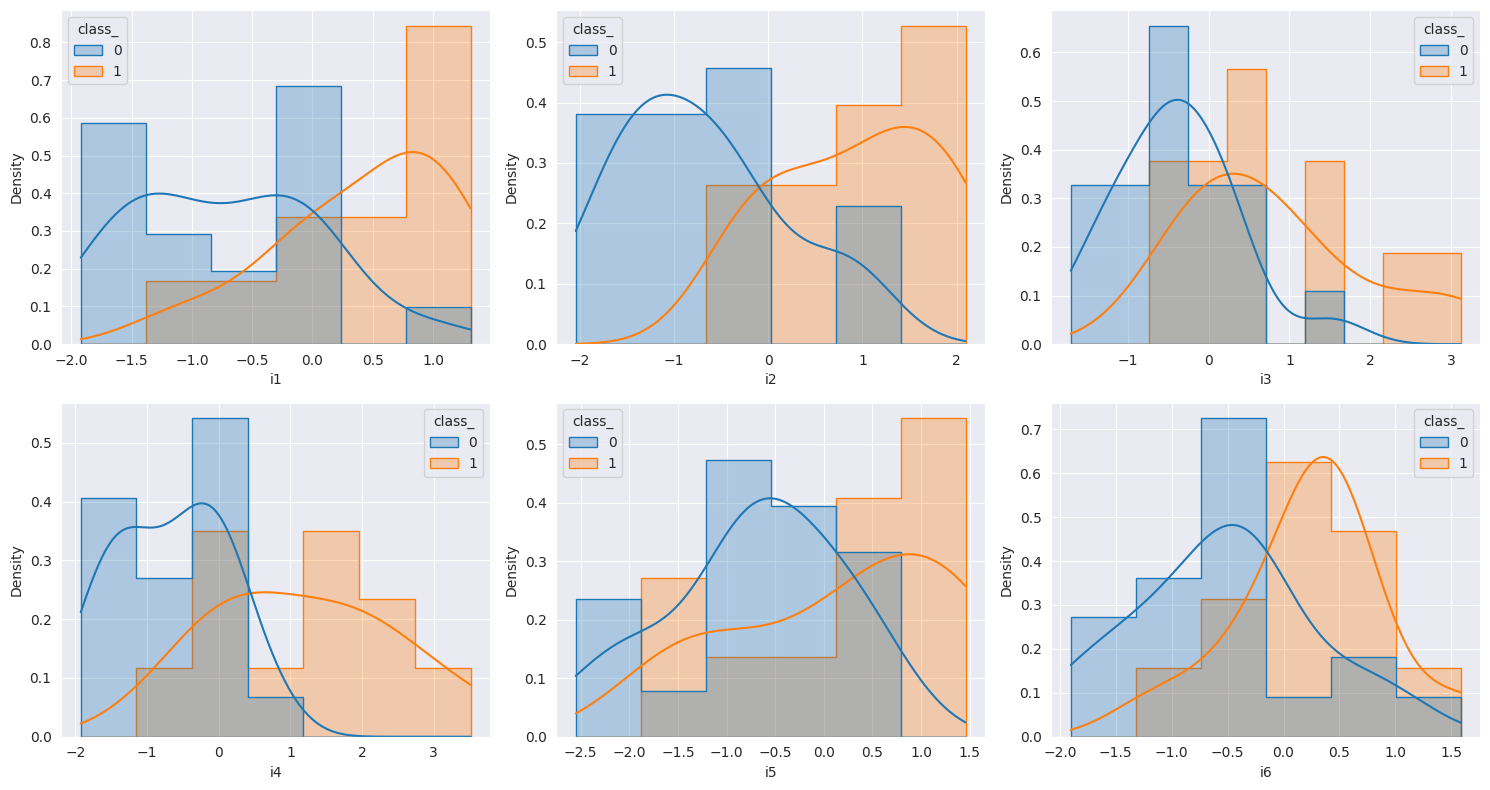

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the first 6 informative columns
informative_cols = [f"i{k}" for k in range(1, 7)]


print(informative_cols)

print(y_informative_base)

# Color by class
# Combine features and class label
df_informative = X_informative_base.copy()
df_informative["class_"] = y_informative_base


fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(informative_cols):
    ax = axes[i // 3, i % 3]
    sns.histplot(
        data=df_informative,
        x=col,
        hue="class_",
        stat="density",
        element="step",
        bins="auto",
        common_norm=False,
        alpha=0.3,
        kde=True,
        ax=ax
    )
    # ax.set_title(f"{col} by class")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

### Check the effect size ranking



In [15]:
# Effect size (Cohen's d) ranking for the informative baseline
def cohen_d(x1, x2):
    """Compute Cohen's d for two samples."""
    n1, n2 = len(x1), len(x2)
    mean1, mean2 = np.mean(x1), np.mean(x2)
    s1, s2 = np.std(x1, ddof=1), np.std(x2, ddof=1)
    # Pooled standard deviation
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    return (mean1 - mean2) / s_pooled if s_pooled > 0 else 0.0
# Compute Cohen's d for each feature
effect_sizes = {}
for col in X_informative_base.columns:
    d = cohen_d(X_informative_base[col][y_informative_base == 0],
                X_informative_base[col][y_informative_base == 1])
    effect_sizes[col] = abs(d)  # use absolute value for ranking
# Create a DataFrame for easy viewing
effect_size_df = pd.DataFrame.from_dict(effect_sizes, orient='index', columns=['Cohen_d']).sort_values(by='Cohen_d', ascending=False)
effect_size_df.index.name = 'Feature'
display(effect_size_df)

,Cohen_d
Feature,
i2,2.833546
i6,2.072365
i8,1.996349
i4,1.596116
i3,1.070087
i5,0.905785
i1,0.810616
i7,0.762549


## Step 2 — Add k irrelevant (noise) features

We now extend the baseline by adding **purely random (irrelevant) features**.
These features carry no signal about the label `y` and should be uncorrelated with the informative block.

We'll start with `n_noise = 12` noise features drawn from a **normal** distribution with unit scale.

We will now **add k purely random (irrelevant) features** by setting `n_noise > 0` and choosing a
`noise_distribution` (e.g., `normal`, `uniform`, or `laplace`).
We will then confirm the new ground-truth roles via `meta.noise_idx` and explore their distributions.

In [ ]:
cfg_noise_normal = DatasetConfig(
    n_samples=30,
    n_informative=8,
    n_pseudo=0,
    n_noise=12,               # add 12 pure-noise features
    n_classes=2,
    class_sep=4,
    feature_naming="prefixed",  # i1..i8, n1..n12
    noise_distribution=NoiseDistribution.normal,  # or just "normal"
    noise_scale=1.0,           # std for normal noise
    random_state=42,
)

Xn, yn, meta_n = generate_dataset(cfg_noise_normal, return_dataframe=True)

print(f"Xn shape: {Xn.shape}, yn shape: {yn.shape}")
Xn.head(3)

### Why these generator settings?

- **`n_informative=8`** keeps the true signal fixed across all comparisons, so any change in model performance can be attributed to the amount/type of **noise** we add.
- **`feature_naming="prefixed"`** produces readable names:
  - `i1, i2, …` for informative features
  - `n1, n2, …` for noise features
  This matches the ground truth recorded in `meta`.
- **Noise semantics**:
  - `noise_distribution="normal"` uses `noise_scale` as **standard deviation**.
  - `noise_distribution="uniform"` uses `noise_scale` as **half-width** of the interval `[-scale, +scale]`.
  - `noise_distribution="laplace"` uses `noise_scale` as the **Laplace scale** (heavier tails).
- **Reproducibility**: `random_state=42` ensures identical datasets each time this cell is re-run.

In [ ]:
# Check that we have 8 informative + 12 noise features and zero pseudo
print("Informative features:", len(meta_n.informative_idx))
print("Pseudo features    :", len(meta_n.pseudo_idx))
print("Noise features     :", len(meta_n.noise_idx))

assert len(meta_n.informative_idx) == 8
assert len(meta_n.pseudo_idx) == 0
assert len(meta_n.noise_idx) == 12

# Show the first few informative and noise columns for a quick glance
cols_show = [f"i{k}" for k in range(1, 5)] + [f"n{k}" for k in range(1, 5)]
Xn[cols_show].head(5)

### Inspect distributions (normal noise)

With `noise_distribution="normal"` and `noise_scale=1.0`, we expect:
- Approximately zero mean and unit variance for noise columns.
- No visible class separation in the noise columns.
- Similar spread across noise columns, up to sampling variability.


In [ ]:
import matplotlib.pyplot as plt

noise_cols = [f"n{k}" for k in range(1, 13)]

# Color by class
# Combine features and class label
df_noise = Xn.copy()
df_noise["class_"] = yn


fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, col in enumerate(noise_cols):
    ax = axes[i // 3, i % 3]
    sns.histplot(
        data=df_noise,
        x=col,
        hue="class_",
        stat="density",
        element="step",
        bins="auto",
        common_norm=False,
        alpha=0.3,
        kde=True,
        ax=ax
    )
    # ax.set_title(f"{col} by class")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()


# # Plot histogram for one noise feature, colored by class
# plt.figure(figsize=(6, 4))
# sns.histplot(
#     data=df_noise,
#     x="n1",           # change to any noise feature, e.g., "n2", "n3", etc.
#     hue="class_",
#     stat="density",
#     element="step",
#     bins="auto",
#     common_norm=False,
#     alpha=0.3,
#     kde=True
# )
# plt.title("Histogram & KDE of n1 by class")
# plt.xlabel("n1")
# plt.ylabel("Density")
# plt.tight_layout()
# plt.show()
#
# # Simple histograms
# for col in noise_cols:
#     plt.figure()
#     Xn[col].hist(bins=30)
#     plt.title(f"Histogram: {col}")
#     plt.xlabel(col)
#     plt.ylabel("Count")
#     plt.show()

### How to read the histograms

- **Informative features (`i*`)** will often show **class-conditional shifts** (or different spreads), hinting at separability.
- **Noise features (`n*`)** should look class-agnostic: the overlaid distributions for the two classes (if visualized) should nearly coincide.
- With **small `n_samples`**, sampling variation is expected—don’t over-interpret minor bumps or slight mean shifts in a single run.

## Step 3 — Uniform noise

Now we switch to `noise_distribution="uniform"`.
Here, `noise_scale` acts as the **half-width** of the interval, i.e. values are roughly in `[-scale, +scale]`.

We’ll use `noise_scale=2.0`, so noise features should mostly lie in `[-2, 2]` with a flat-ish density.

In [ ]:
cfg_noise_uniform = DatasetConfig(
    n_samples=30,
    n_informative=8,
    n_pseudo=0,
    n_noise=12,
    n_classes=2,
    class_sep=1.2,
    feature_naming="prefixed",
    noise_distribution=NoiseDistribution.uniform,
    noise_scale=2.0,            # half-width for uniform
    random_state=42,
)

Xu, yu, meta_u = generate_dataset(cfg_noise_uniform, return_dataframe=True)

print(f"Xu shape: {Xu.shape}, yu shape: {yu.shape}")
print("Noise columns (first 5):", [f"n{k}" for k in range(1, 6)])

# Empirical min/max of first 5 noise columns to verify ~[-2, 2]
mins = Xu[[f"n{k}" for k in range(1, 6)]].min().round(3)
maxs = Xu[[f"n{k}" for k in range(1, 6)]].max().round(3)
display(pd.DataFrame({"min": mins, "max": maxs}))

### Uniform noise expectations

With `noise_distribution="uniform"` and `noise_scale=2.0`, values are roughly in **`[-2, 2]`**.
You should observe:
- Empirical **min/max** close to −2 and +2 (but not equal—finite samples fall short of true bounds).
- **Nearly constant density** within the interval, unlike the bell shape of normal noise.

### Sanity check: correlations

Irrelevant features should be **uncorrelated** with `y` (up to sampling noise) and show no systematic correlation with informative features.

We’ll compute:
- Absolute correlation between each **noise** feature and the **label** `y`.
- Maximum absolute correlation between **noise** and **informative** features.


In [ ]:
# Work on the uniform-noise dataset (Xu, yu, meta_u)
informative_columns = [f"i{k}" for k in range(1, len(meta_u.informative_idx)+1)]
noise_columns = [f"n{k}" for k in range(1, len(meta_u.noise_idx)+1)]

# Correlation of noise with the label (point-biserial via pandas corr with numeric y)
yu_numeric = pd.Series(yu, name="y").astype(float)

noise_y_corr = (
    Xu[noise_columns].apply(lambda s: s.corr(yu_numeric)).abs().sort_values(ascending=False)
)
print("Top 5 |abs(corr(noise, y))| (should be modest due to randomness):")
display(noise_y_corr.head(5).round(3))

# Max |corr| between noise and any informative feature
corr_matrix = Xu[informative_columns + noise_columns].corr().abs()
max_noise_inf = corr_matrix.loc[informative_columns, noise_columns].max().sort_values(ascending=False)
print("Top 5 max |corr| between informative and noise (should be modest):")
display(max_noise_inf.head(5).round(3))

### Spurious correlations grow with dimensionality

Even if each noise feature is uninformative, the **largest absolute correlation** among many noise variables can be non-trivial **by chance**.

Rule of thumb (for intuition): the maximum spurious correlation scales roughly like
$$
\max_j \lvert r_{j,y}\rvert \sim \sqrt{\tfrac{2\log p}{n}}
$$
where \(p\) is the number of features and \(n\) the sample size.


➡️ As you add more noise features or reduce sample size, **chance correlations** become more prominent.


## Step 4 — Increase number of noise features + cross-validated model performance

We now study how *increasing the number of irrelevant (noise) features* affects model performance feature selection stability and false discoveries. We measure how a simple linear classifier (Logistic Regression) behaves under **Stratified 5-Fold CV** as we increase the number of noise features.


**Plan**
1. Keep the true signal fixed: 8 informative features, same effect size/separability.
2. Vary the number of **pure noise** features: e.g. `k ∈ {0, 50, 200, 1000}`.
3. Train a simple linear classifier (Logistic Regression) **with scaling** and evaluate via **Stratified 5-Fold CV**. We keep the model fixed to isolate the effect of dimensionality.
4. Only one factor changes: the number of irrelevant features.
5. Track:
   - **Balanced accuracy** (robust to small class imbalances)
   - **Feature discovery** quality via a simple univariate ranking (precision@k; false discoveries among top-k)

> Note: For stability, we use `n_samples=120` for this sweep (a bit larger than the earlier 30). We keep this fixed to isolate the effect of dimensionality.

In [ ]:
# Experiment configuration

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import balanced_accuracy_score, make_scorer

# Fixed signal & CV settings
SEED = 42
N_SAMPLES = 120
N_INFORMATIVE = 8
CLASS_SEP = 1.2

# Noise counts to sweep over
NOISE_COUNTS = [0, 50, 200, 1000]

# Estimator: scale -> logistic regression (binary)
# liblinear is robust for small-sample, L2 by default
ESTIMATOR = make_pipeline(
    RobustScaler(),
    LogisticRegression(solver="liblinear", random_state=SEED, max_iter=2000)
)

CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
SCORER = make_scorer(balanced_accuracy_score)

### Why logistic regression + scaling?

- **Logistic Regression** is a transparent linear baseline; with L2 regularization it copes reasonably with moderate noise.
- **RobustScaler** avoids feature-scale dominance and reduces optimization issues. Robust scaling (median + IQR) is less sensitive to outliers than standard scaling (mean + std).
- The pipeline ensures **no data leakage**: scaling parameters are learned **inside** each CV fold.
- Alternatives to try later:
  - **Linear SVM** (hinge loss) for a similar linear margin-based view.
  - **Elastic Net** for embedded sparsity (tuning needed).
  - **Tree ensembles** (e.g. Random Forests) for non-linear baselines.


In [ ]:
# Dataset factory (using biomedical-data-generator)
def make_dataset(n_noise: int,
                 noise_dist: NoiseDistribution = NoiseDistribution.normal,
                 noise_scale: float = 1.0,
                 *,
                 n_samples: int = N_SAMPLES,
                 n_informative: int = N_INFORMATIVE,
                 class_sep: float = CLASS_SEP,
                 seed: int = SEED):
    """
    Build a dataset with a fixed informative block and variable number of pure-noise features.
    Returns: (X_df, y_np, meta)
    """
    cfg1 = DatasetConfig(
        n_samples=n_samples,
        n_informative=n_informative,
        n_pseudo=0,
        n_noise=n_noise,
        n_classes=2,
        class_sep=class_sep,
        feature_naming="prefixed",      # i1..iK, n1..nK
        noise_distribution=noise_dist,  # "normal" | "uniform" | "laplace"
        noise_scale=noise_scale,
        random_state=seed,
    )
    X_df, y_np, meta_data = generate_dataset(cfg1, return_dataframe=True)
    return X_df, y_np, meta_data


### Guarding against leakage in CV

By wrapping preprocessing and the estimator in a **single pipeline** and passing it to `cross_val_score`, we guarantee that:
- **Scaling** and **model fitting** occur **only on the training folds**.
- The held-out fold remains unseen until scoring, yielding **honest** performance estimates.


In [ ]:
# CV evaluation helper
def evaluate_cv(X_df: pd.DataFrame, y_np: np.ndarray,
                estimator=ESTIMATOR,
                cv=CV,
                scorer=SCORER) -> tuple[float, float]:
    """
    Returns (mean_bal_acc, std_bal_acc) from K-fold CV.
    """
    scores = cross_val_score(estimator, X_df, y_np, cv=cv, scoring=scorer, n_jobs=None)
    return float(scores.mean()), float(scores.std())

### On the feature discovery metric

We use a **univariate ranking** (|corr| with `y`) to keep things simple and fast:

- Reports **precision@k** with \(k=\) number of truly informative features.
- Counts **false discoveries in top-k** (noise among the top-ranked features).

**Limitations**:
- Ignores **feature interactions** and **correlation structure**.
- Sensitive to **outliers** and **class imbalance**.

Later extensions could use permutation importance, or embedded coefficients with **nested CV** for fair model-based selection.


In [ ]:
#Simple feature discovery metric (precision@k and false discoveries)
def precision_at_k_by_abs_corr(X_df: pd.DataFrame, y_np: np.ndarray, meta_data, k: int | None = None) -> dict:
    """
    Rank features by absolute Pearson correlation with y (point-biserial for binary y).
    Compute precision@k where k defaults to the number of informative features.
    Also report the number of noise features in top-k (false discoveries).
    """
    y_series = pd.Series(y_np, name="y").astype(float)
    # absolute correlation with y (skip non-finite if any)
    abs_corr = X_df.apply(lambda s: s.corr(y_series)).abs().sort_values(ascending=False)

    if k is None:
        k = len(meta_data.informative_idx)

    topk = list(abs_corr.index[:k])

    # Map ground truth: indices -> column names
    informative_columns_list = list(X_informative_base.columns.take(meta_data.informative_idx))
    noise__columns_list = list(X_informative_base.columns.take(meta_data.noise_idx))

    tp = sum(colum in informative_columns_list for colum in topk)
    fp = sum(colum in noise__columns_list for colum in topk)  # false discoveries among top-k
    prec = tp / k if k > 0 else np.nan

    return {
        "k": k,
        "precision_at_k": prec,
        "false_discoveries_topk": fp,
        "tp_topk": tp,
    }


### Run the sweep over noise counts, collecting balanced accuracy and feature discovery metrics

In [ ]:
def run_sweep(noise_counts, noise_dist, noise_scale) -> pd.DataFrame:
    results = []
    for k_noise in noise_counts:
        Xk, yk, meta_k = make_dataset(n_noise=k_noise, noise_dist=noise_dist, noise_scale=noise_scale)
        mean_ba, std_ba = evaluate_cv(Xk, yk)
        disc = precision_at_k_by_abs_corr(Xk, yk, meta_k, k=len(meta_k.informative_idx))
        results.append({
            "dist": str(noise_dist),
            "scale": noise_scale,
            "n_noise": k_noise,
            "n_informative": len(meta_k.informative_idx),
            "bal_acc_mean": mean_ba,
            "bal_acc_std": std_ba,
            "precision_at_k": disc["precision_at_k"],
            "false_discoveries_topk": disc["false_discoveries_topk"],
            "tp_topk": disc["tp_topk"],
        })
    return pd.DataFrame(results).sort_values("n_noise").reset_index(drop=True)

result_df = run_sweep(NOISE_COUNTS, NoiseDistribution.normal, 1.0)

# results = []
#
# for k_noise in NOISE_COUNTS:
#     Xk, yk, meta_k = make_dataset(n_noise=k_noise, noise_dist=NoiseDistribution.normal, noise_scale=1.0)
#
#     mean_ba, std_ba = evaluate_cv(Xk, yk)
#
#     # feature discovery at k = number of informative features
#     disc = precision_at_k_by_abs_corr(Xk, yk, meta_k, k=len(meta_k.informative_idx))
#
#     results.append({
#         "n_noise": k_noise,
#         "n_informative": len(meta_k.informative_idx),
#         "n_samples": len(yk),
#         "bal_acc_mean": mean_ba,
#         "bal_acc_std": std_ba,
#         "precision_at_k": disc["precision_at_k"],
#         "false_discoveries_topk": disc["false_discoveries_topk"],
#         "tp_topk": disc["tp_topk"],
#     })
#
# res_df = pd.DataFrame(results).sort_values("n_noise").reset_index(drop=True)
# res_df

### What trends to expect

- **Balanced accuracy** typically **decreases** as `n_noise` increases (harder signal recovery).
- **Precision@k** falls with more noise—top-k becomes increasingly contaminated by chance hits.
- **False discoveries** in top-k grow with dimensionality, even for honest univariate filters.

### Computational notes

- This sweep is lightweight (single model, 5-fold CV).
- As you add methods (e.g., nested CV, repeated subsampling, multiple models), runtime will grow quickly.
- Keep random seeds fixed for **comparability**, and cache intermediate results when exploring many settings.


### Plot results

In [ ]:
import matplotlib.pyplot as plt

# Balanced accuracy vs number of noise features
plt.figure()
plt.plot(result_df["n_noise"], result_df["bal_acc_mean"], marker="o")
plt.title("Balanced accuracy vs number of noise features")
plt.xlabel("Number of noise features")
plt.ylabel("Balanced accuracy (CV mean)")
plt.show()

# Precision@k vs number of noise features
plt.figure()
plt.plot(result_df["n_noise"], result_df["precision_at_k"], marker="o")
plt.title("Precision@k (k = #informative) vs number of noise features")
plt.xlabel("Number of noise features")
plt.ylabel("Precision@k")
plt.show()

# False discoveries among top-k vs number of noise features
plt.figure()
plt.plot(result_df["n_noise"], result_df["false_discoveries_topk"], marker="o")
plt.title("False discoveries in top-k vs number of noise features")
plt.xlabel("Number of noise features")
plt.ylabel("False discoveries (count) in top-k")
plt.show()


### Reading the plots carefully

- Expect **non-monotonic fluctuations** due to finite-sample randomness—don’t over-fit to a single curve.
- Look for the **overall slope**: does performance degrade roughly as dimensionality rises?
- If a method looks unusually stable, verify you are **not leaking information** and that regularization is properly tuned.

### Interpretation checklist

- **Performance drop**: As `n_noise` grows, balanced accuracy should typically **decrease** unless regularization and sample size are strong.
- **Ranking dilution**: Simple univariate rankings (abs corr) become **less precise** as dimensionality grows; expect **lower precision@k** and **more false discoveries**.
- **Sample size matters**: With fixed effect size, increasing `n_samples` generally improves both performance and discovery metrics.
- **Regularization**: Linear models with proper regularization can resist some noise, but the *curse of dimensionality* still applies.


### Biomedical context: why this matters

Omics datasets (e.g., gene expression, proteomics, methylation) often have **p ≫ n**:
- Thousands of features with **few dozens of samples**.
- Many features are unrelated to the phenotype—i.e., **irrelevant** for prediction.

Understanding how irrelevant features affect **generalization** and **feature discovery** helps you:
- Choose appropriate **regularization** and **model families**,
- Design **feature selection** protocols that avoid false discoveries,
- Plan for **validation** on independent cohorts.


## Step 5 — Comparing noise distributions

Repeat the sweep with:
- `noise_distribution="uniform", noise_scale=2.0` (values roughly in `[-2, 2]`)
- `noise_distribution="laplace", noise_scale=1.0` (heavier tails)

Then compare curves (balanced accuracy, precision@k) across distributions.

In [ ]:
df_uniform = run_sweep(NOISE_COUNTS, NoiseDistribution.uniform, 2.0)
df_laplace = run_sweep(NOISE_COUNTS, NoiseDistribution.laplace, 1.0)
display(df_uniform, df_laplace)

### Comparing noise distributions

- **Uniform** noise (bounded support) usually yields tighter extremes than normal at small `n`, reducing outlier risks.
- **Laplace** noise (heavier tails) increases the chance of **extreme values**, which can inflate spurious correlations and destabilize rankings.
- When sweeping distributions, keep **`n_samples`, `n_informative`, and `class_sep`** fixed to isolate the distributional effect.


### Comparing noise distributions

- **Uniform** noise (bounded support) usually yields tighter extremes than normal at small `n`, reducing outlier risks.
- **Laplace** noise (heavier tails) increases the chance of **extreme values**, which can inflate spurious correlations and destabilize rankings.
- When sweeping distributions, keep **`n_samples`, `n_informative`, and `class_sep`** fixed to isolate the distributional effect.


## Step 2: Add k purely random (irrelevant) features

In [ ]:
# Add k purely random (irrelevant) features
rng = np.random.default_rng(7)

def add_noise_features(df, k=10, dist="normal", seed=None):
    """Append k random columns to df (excluding 'class')."""
    rng_local = np.random.default_rng(seed)
    out = df.copy()
    n = len(df)
    for i in range(k):
        if dist == "normal":
            noise = rng_local.normal(loc=0.0, scale=1.0, size=n)
        elif dist == "uniform":
            noise = rng_local.uniform(low=-1.0, high=1.0, size=n)
        else:
            raise ValueError("Supported dists: 'normal', 'uniform'")
        out[f"noise_{i+1}"] = noise
    return out

df_noise = add_noise_features(df, k=10, dist="normal", seed=123)
noise_cols = [c for c in df_noise.columns if c.startswith("noise_")]
len(noise_cols), noise_cols[:5]


### What do noise features look like?
- **Definition:** Noise (irrelevant) features have **no relationship** to the class label.
- **Visual expectation:** Their class-conditional distributions should **overlap heavily**.
- We'll compare one **informative** feature with one **noise** feature.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick one likely-informative feature and one noise feature
informative_example = "feature_8"
noise_example = noise_cols[0]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.kdeplot(data=df_noise, x=informative_example, hue="class", common_norm=False)
plt.title(f"Informative example: {informative_example}")

plt.subplot(1,2,2)
sns.kdeplot(data=df_noise, x=noise_example, hue="class", common_norm=False)
plt.title(f"Noise example: {noise_example}")

plt.tight_layout()
plt.show()

### Effect size check
Visual impressions can be misleading. Let’s **quantify** class separation for the two features using **Cohen’s d**.
- Expect **larger d** for informative features.
- Expect **near 0** for noise features.


In [ ]:
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

g0_inf = df_noise.loc[df_noise["class"] == 0, informative_example]
g1_inf = df_noise.loc[df_noise["class"] == 1, informative_example]
g0_noise = df_noise.loc[df_noise["class"] == 0, noise_example]
g1_noise = df_noise.loc[df_noise["class"] == 1, noise_example]

d_inf = cohens_d(g0_inf, g1_inf)
d_noise = cohens_d(g0_noise, g1_noise)

print(f"Cohen's d — {informative_example}: {d_inf:.2f}")
print(f"Cohen's d — {noise_example}: {d_noise:.2f}")


In [ ]:
# Rank base + noise features by absolute Cohen's d (bigger = more separating)
all_feats = [c for c in df_noise.columns if c != "class"]
rows = []
for col in all_feats:
    a = df_noise.loc[df_noise["class"] == 0, col].values
    b = df_noise.loc[df_noise["class"] == 1, col].values
    d = cohens_d(a, b)
    rows.append({"feature": col, "cohens_d": d, "abs_d": abs(d)})

rank_df = pd.DataFrame(rows).sort_values("abs_d", ascending=False)
rank_df.head(12)


#### Interpretation & Reflection
- **Ranking** by |d| should list informative features near the top and noise features near the bottom.
- **Check:** Do `feature_*` columns dominate the top? Are `noise_*` near the bottom?

**Try this:**
- Increase the number of noise features to 100 in `add_noise_features`.
  - Does the top-10 list still capture informative features?
- Change the noise distribution to `"uniform"`.
  - Any difference in the ranking?


In [ ]:
# Optional: train a simple classifier to see if noise hurts performance when abundant
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_informative_base = df_noise.drop(columns=["class"]).values
y_informative_base = df_noise["class"].values

X_tr, X_te, y_tr, y_te = train_test_split(X_informative_base, y_informative_base, test_size=0.3, random_state=0, stratify=y_informative_base)

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
clf.fit(X_tr, y_tr)
pred = clf.predict(X_te)
print("Logistic Regression accuracy:", round(accuracy_score(y_te, pred), 3))


### Reflection

Take a moment to connect the code results with the concepts:

- **Visual inspection**:
  - Did the noise features look different from the informative ones in the histograms/KDE plots?
  - Could you spot noise features by eye alone?

- **Effect size**:
  - Did the calculated Cohen’s d values match your visual impression?
  - Were the informative features ranked higher than the noise features?

- **Model performance** (if you ran the optional classifier):
  - How much did adding noise affect classification accuracy?
  - What might happen if you add *hundreds* of noise features?

**Think ahead**:
In real biomedical studies, many measured variables are irrelevant.
Why is it important to detect and filter them before applying complex models?

## Exercises

1. **Add random noise features**
   - Extend your dataset with 5–10 new columns of purely random numbers
     (e.g., `np.random.normal`).
   - **Observation goal:** Do the class distributions change?
   - **Why this matters:** In real-world data, irrelevant measurements are
     always present. Models must learn to ignore them.

2. **Increase the number of irrelevant features**
   - Add 100 random features instead of 5.
   - Train a simple classifier.
   - **Observation goal:** Does performance change? Does training take longer?
   - **Why this matters:** More noise makes feature selection harder and
     increases the risk of overfitting.

> **Takeaway:**
> Irrelevant features dilute the signal. Synthetic data allows us to
> control how much noise exists, so we can test how methods behave in
> high-noise vs. low-noise scenarios.

## Quick Takeaway (3a)
- **Irrelevant features** add no predictive value and can **dilute** signal.
- Visually, noise features show **strong overlap** between classes.
- **Effect size** (e.g., Cohen’s d) helps **quantify** which features are informative.
- In high-noise settings, feature selection (next module) becomes crucial.


## Next Steps

In **Lesson 3b: Correlated Features**, you will:
- Simulate features that **move together** (e.g., biological pathways).
- Visualize correlation structures (heatmaps, pairplots).
- See how **redundancy** complicates analysis.

➡️ Continue with: **[`03b_correlated_features.ipynb`](03b_correlated_features.ipynb)`**


# Synthetic Biomedical Data – Lesson 3a: Irrelevant Features (Noise)

Part of the *Microcredit Artificial Data Generator* learning module.

➡️ [Back to Lesson 2b: Feature Distributions and Effect Size](02b_feature_distributions_effect_size.ipynb)
➡️ [Module Overview (README)](../README.md)

---

### Recap from Lesson 2
In the previous lesson, you:
- Generated your first **synthetic dataset** with controlled parameters
  (number of samples, features, and classes).
- Explored the **class distribution** to check balance between categories.
- Visualized class separability with a **scatterplot** of two features.
- Examined **feature distributions per class** using histograms, and saw that:
  - Some features are clearly informative.
  - Others behave like **noise** and do not separate classes well.

**Key takeaway:**
Synthetic datasets can be created and explored just like real biomedical data,
but with the advantage that we know which features are informative and which are not.
This makes them a safe playground for building intuition and testing methods.

---

### What’s next?

In the next lessons, we make our synthetic datasets more realistic by adding
common sources of complexity found in biomedical data.
Building on Lesson 2 (basic dataset generation), we now introduce:

- **Irrelevant features** — variables that do not contribute useful information (pure noise).
- **Correlated features** — features that move together, similar to biomarkers in the same biological pathway or proteins in the same signaling cascade.
- **Pseudo-classes** — made-up categories that mimic real subgroups but do not truly relate to the outcome.
- **Random effects** — systematic variation caused by external conditions (e.g., measurement day, lab instrument).

These additions make synthetic data more similar to real biomedical datasets,
where signals are rarely clean, features are often interdependent, and confounding effects are common.
They also provide a controlled playground to study how algorithms handle **noise, redundancy, and dependency**.

---

### Why this lesson: Irrelevant features?
In real biomedical datasets, not all collected measurements are useful.
Some features carry no signal about the outcome and act as **irrelevant features (noise)**.
If too many irrelevant features are present, they can:
- Make it harder to identify true biomarkers.
- Increase model complexity and training time.
- Lead to **overfitting** if models start learning patterns in the noise.

Synthetic data allows us to deliberately add irrelevant features to test how models and methods cope with them.

---

### Learning Goals for Lesson 3a
After completing this notebook, you will be able to:
1. **Add irrelevant features** (pure noise) to a synthetic dataset.
2. **Visualize** how irrelevant features appear in histograms and scatterplots.
3. **Compare** informative vs. irrelevant features quantitatively using effect size.
4. **Explain** why irrelevant features complicate feature selection and model training.
5. Build intuition for how **noise levels** affect machine learning performance.


# Lesson 3a: Irrelevant Features (Noise)

In the previous lesson, you generated and explored basic synthetic datasets.
Now we ask: *what happens if we add measurements that are completely unrelated to the outcome?*

### Learning Goals
- Understand the concept of **irrelevant features** (pure noise).
- Simulate irrelevant features in synthetic data.
- Explore their effect on visualization and classification.

---

## Concept
Not all measurements in a dataset are useful. Many real biomedical datasets
contain features that are unrelated to the outcome.

- **Example:** A patient’s eye color when predicting heart disease.
- These features add **noise** and can make analysis harder.

---

## Exercises
1. **Add random noise features**
   - Generate new columns with random numbers.
   - Inspect whether the class distribution changes.

2. **Increase number of irrelevant features**
   - Add 100 random features instead of 5.
   - Train a simple classifier and observe runtime/performance.

---

## Quick Takeaway
- Irrelevant features dilute the signal.
- More noise makes learning harder and increases the risk of overfitting.

---

## Next Steps
Proceed to **Lesson 3b: Correlated Features**.


## 3.1 Irrelevant Features (Noise)

Not all measurements in a dataset are useful. In fact, many real datasets
contain features that are unrelated to the outcome.

- **Example in biology:** a patient’s eye color when predicting heart disease.
- **Risk:** Models can waste capacity on noise or even mistake it for signal
  when many irrelevant features are present.
  -
- **Goal here:** learn how to add irrelevant features and see how they
  affect visualization and downstream analysis.

**TODO**: Add code to generate a dataset with a few random noise features
(e.g., `np.random.normal` values added as extra columns).

### Exercises

1. **Add random noise features**
   - Extend your dataset with 5–10 new columns of purely random numbers
     (e.g., `np.random.normal`).
   - **Observation goal:** Do the class distributions change?
   - **Why this matters:** In real-world data, irrelevant measurements are
     always present. Models must learn to ignore them.

2. **Increase the number of irrelevant features**
   - Add 100 random features instead of 5.
   - Train a simple classifier.
   - **Observation goal:** Does performance change? Does training take longer?
   - **Why this matters:** More noise makes feature selection harder and
     increases the risk of overfitting.

> **Takeaway:**
> Irrelevant features dilute the signal. Synthetic data allows us to
> control how much noise exists, so we can test how methods behave in
> high-noise vs. low-noise scenarios.